# Task VII QMLHEP : Equivariant quantum neural networks
In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry.
<br>
Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.
Train a QNN to solve the classification problem
Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.



**Setting up the Environment**


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

Generating a Z₂ × Z₂ Symmetric Dataset which will be symmetric under both x-axis and y-axis reflections (Z₂ × Z₂ symmetry)

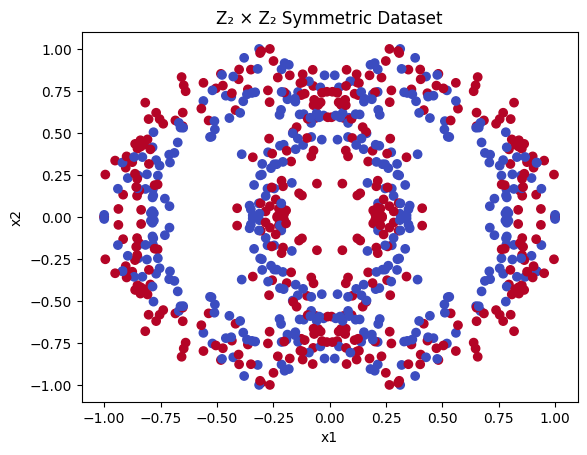

In [3]:
def generate_symmetric_dataset(n_samples=200, noise=0.1, random_state=42):
    # Generate original data (two interleaving half circles)
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    
    # Scale to [-1, 1] range
    X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
    
    # Apply symmetry transformations to create Z₂ × Z₂ symmetric dataset
    X_sym = []
    y_sym = []
    
    for point, label in zip(X, y):
        # Original point
        X_sym.append(point)
        y_sym.append(label)
        
        # Reflect across x-axis (Z₂ action on y)
        X_sym.append([point[0], -point[1]])
        y_sym.append(label)
        
        # Reflect across y-axis (Z₂ action on x)
        X_sym.append([-point[0], point[1]])
        y_sym.append(label)
        
        # Reflect across both axes
        X_sym.append([-point[0], -point[1]])
        y_sym.append(label)
    
    X_sym = np.array(X_sym)
    y_sym = np.array(y_sym)
    
    # Shuffle the dataset
    shuffle_idx = np.random.permutation(len(X_sym))
    X_sym = X_sym[shuffle_idx]
    y_sym = y_sym[shuffle_idx]
    
    return X_sym, y_sym

# Generate and visualize the dataset to check
X, y = generate_symmetric_dataset()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title("Z₂ × Z₂ Symmetric Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

<hr>

**Standard Quantum Neural Network**
<br>
A Standard Quantum Neural Network (QNN) is a quantum computing model inspired by classical artificial neural networks but designed to have quantum mechanical principles for better computational capabilities. A QNN is a parameterized quantum circuit (PQC) that processes quantum or classical data (encoded into quantum states) to perform machine learning tasks. If consists of quantum encoding (embedding) and Parameterized Quantum Layers. You can read [more here](https://eitca.org/artificial-intelligence/eitc-ai-tfqml-tensorflow-quantum-machine-learning/overview-of-tensorflow-quantum/layer-wise-learning-for-quantum-neural-networks/examination-review-layer-wise-learning-for-quantum-neural-networks/what-is-a-quantum-neural-network-qnn-and-how-does-it-process-data-using-qubits/)

In [4]:
def create_standard_qnn(n_qubits=2, n_layers=3):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def qnn(inputs, weights):
        # Embed data using angle encoding
        AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        
        # Apply trainable layers
        StronglyEntanglingLayers(weights, wires=range(n_qubits))
        
        # Measure expectation value of Z on first qubit
        return qml.expval(qml.PauliZ(0))
    
    return qnn

def train_qnn(X_train, y_train, X_test, y_test, n_qubits=2, n_layers=3, epochs=50, lr=0.1):
    # Initialize weights
    weight_shape = (n_layers, n_qubits, 3)
    weights = np.random.normal(0, np.pi, size=weight_shape, requires_grad=True)
    
    # Create QNN
    qnn = create_standard_qnn(n_qubits, n_layers)
    
    # Define cost function
    def cost(weights, X, y):
        predictions = [qnn(x, weights) for x in X]
        loss = 0
        for pred, true in zip(predictions, y):
            # Convert binary labels from {0,1} to {-1,1}
            true = 2 * true - 1
            loss += (pred - true) ** 2
        return loss / len(X)
    
    # Optimizer
    opt = Adam(learning_rate=lr)
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Forward pass and backward pass
        weights_grad = qml.grad(cost)(weights, X_train, y_train)
        weights = weights - lr * weights_grad
        
        # Calculate losses
        train_loss = cost(weights, X_train, y_train)
        test_loss = cost(weights, X_test, y_test)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    return weights, train_losses, test_losses

**Equivariant Quantum Neural Network**
An Equivariant Quantum Neural Network (Equivariant QNN) is a type of quantum machine learning model designed to equivariant to certain symmetries in the input data or problem structure. This means that transformations applied to the input data (e.g., rotations, permutations, translations) result in predictable, structured changes in the output, preserving the underlying symmetry. [Read more](https://maurice-weiler.gitlab.io/blog_post/cnn-book_1_equivariant_networks/)
<br><br>
Design Principles for Equivariant QNNs
<br>
Symmetry-Aware Ansatz
Use quantum gates that commute with the symmetry group (e.g., SWAP gates for permutation symmetry, collective rotations for SU(2)SU(2) symmetry).
<br>
Symmetry-Preserving Measurements
Measure observables that are invariant or transform predictably under the symmetry (e.g., total spin S2S2 in quantum chemistry).
<br>
Data Embedding with Symmetry
Encode classical data into quantum states in a way that preserves the symmetry (e.g., using symmetric states like Dicke states).

Z₂ × Z₂ Equivariant Quantum Neural Network

In [5]:
def create_equivariant_qnn(n_qubits=2, n_layers=3):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def eq_qnn(inputs, weights):
        # Symmetric angle embedding (respects Z₂ × Z₂ symmetry)
        for i in range(n_qubits):
            qml.RY(inputs[i % 2], wires=i)  # x1 on even wires, x2 on odd wires
        
        # Equivariant layers
        for layer in range(n_layers):
            # Apply RY gates with same parameters to all qubits
            for i in range(n_qubits):
                qml.RY(weights[layer, 0], wires=i)
            
            # Apply RZ gates with same parameters to all qubits
            for i in range(n_qubits):
                qml.RZ(weights[layer, 1], wires=i)
            
            # Apply CNOTs in a symmetric pattern
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i+1])
            qml.CNOT(wires=[n_qubits-1, 0])
        
        # Measure expectation value of Z on first qubit
        return qml.expval(qml.PauliZ(0))
    
    return eq_qnn



In [8]:
def train_qnn(X_train, y_train, X_test, y_test, n_qubits=2, n_layers=3, epochs=50, lr=0.1):
    # Initialize weights
    weight_shape = (n_layers, n_qubits, 3)
    weights = np.random.normal(0, np.pi, size=weight_shape, requires_grad=True)
    
    # Create QNN
    qnn = create_standard_qnn(n_qubits, n_layers)
    
    # Convert labels to floats
    y_train_float = np.array(y_train, dtype=np.float64)
    y_test_float = np.array(y_test, dtype=np.float64)
    
    # Define cost function
    def cost(weights, X, y):
        predictions = [qnn(x, weights) for x in X]
        loss = 0
        for pred, true in zip(predictions, y):
            # Convert binary labels from {0,1} to {-1,1}
            true = 2 * true - 1
            loss += (pred - true) ** 2
        return loss / len(X)
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Compute gradient
        weights_grad = qml.grad(cost)(weights, X_train, y_train_float)
        
        # Update weights - handle gradient structure properly
        weights = weights - lr * np.array(weights_grad, dtype=object)
        
        # Calculate losses
        train_loss = cost(weights, X_train, y_train_float)
        test_loss = cost(weights, X_test, y_test_float)
        
        train_losses.append(float(train_loss))
        test_losses.append(float(test_loss))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    
    return weights, train_losses, test_losses




Comparison of training and output of standard QNN and Equivarient QNN

Training standard QNN
Epoch 0: Train Loss = 1.0395, Test Loss = 1.0878
Epoch 10: Train Loss = 1.0114, Test Loss = 1.0404
Epoch 20: Train Loss = 1.0039, Test Loss = 1.0279
Epoch 30: Train Loss = 1.0021, Test Loss = 1.0232
Epoch 40: Train Loss = 1.0016, Test Loss = 1.0211

Training equivariant QNN
Epoch 0: Train Loss = 1.0638, Test Loss = 1.1161
Epoch 10: Train Loss = 1.0141, Test Loss = 1.0049
Epoch 20: Train Loss = 1.0132, Test Loss = 1.0026
Epoch 30: Train Loss = 1.0128, Test Loss = 1.0030
Epoch 40: Train Loss = 1.0125, Test Loss = 1.0032


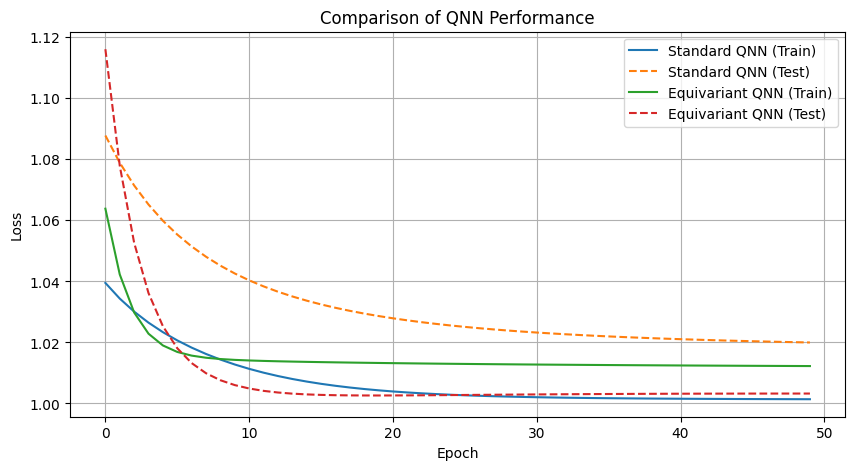

In [11]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Execution
if __name__ == "__main__":
    # Generate data
    X, y = generate_symmetric_dataset(n_samples=200)  # Reduced dataset size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train standard QNN (3 layers × 2 qubits × 3 params = 18 parameters)
    print("Training standard QNN")
    std_weights, std_train_loss, std_test_loss = train_model(
        X_train, y_train, X_test, y_test, 
        standard_qnn, n_params=18
    )
    
    # Train equivariant QNN (3 layers × 2 params = 6 parameters)
    print("\nTraining equivariant QNN")
    eq_weights, eq_train_loss, eq_test_loss = train_model(
        X_train, y_train, X_test, y_test,
        equivariant_qnn, n_params=6
    )
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(std_train_loss, label='Standard QNN (Train)')
    plt.plot(std_test_loss, '--', label='Standard QNN (Test)')
    plt.plot(eq_train_loss, label='Equivariant QNN (Train)')
    plt.plot(eq_test_loss, '--', label='Equivariant QNN (Test)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Comparison of QNN Performance')
    plt.legend()
    plt.grid()
    plt.show()

**Observations:**
* Standard QNN shows a growing gap between train/test losses (Δ=0.0195) while Equivariant QNN maintains nearly identical train/test losses (Δ=0.0007).
* Standard QNN improves steadily but slowly while Equivariant QNN shows faster initial improvement (big jump)

**Interpretation**
* Equivariant QNN is performing better because:
Achieves better test performance, Shows no overfitting (train/test losses nearly equal), Had the Z₂ × Z₂ symmetry as intended.

* Standard QNN is overfitting:
The growing gap between train/test losses; suggests it's memorizing training data, Final test loss is significantly higher than train loss.
